<a href="https://colab.research.google.com/github/GulsumSayin/OSCC-Histopathology-Classification/blob/main/OSCC_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
import os
import numpy as np
import shutil
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 Orijinal veri klasörü
original_dir = "/content/drive/MyDrive/datasets"  # İçerik: /normal, /oscc

# 🎯 Hedef sayılar
TARGET_COUNT = 1500

# 📁 Kayıt klasörü
augmented_dir = "/content/drive/MyDrive/augmented_balanced_data"
shutil.rmtree(augmented_dir, ignore_errors=True)  # Varsa sil

# 🔁 Augmenter (gerçek augmentasyon için)
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

for cls in ['normal', 'oscc']:
    cls_dir = os.path.join(original_dir, cls)
    images = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(images)
    print(f"🔍 {cls} mevcut: {current_count}")

    # Kayıt klasörü oluştur
    save_cls_dir = os.path.join(augmented_dir, cls)
    os.makedirs(save_cls_dir, exist_ok=True)

    # Orijinalleri kopyala
    for img_name in images:
        shutil.copy(os.path.join(cls_dir, img_name), os.path.join(save_cls_dir, img_name))

    # Augmentasyon ile hedefe tamamla
    pbar = tqdm(total=TARGET_COUNT - current_count, desc=f"Augmenting {cls}")
    idx = 0
    aug_idx = 0
    while len(os.listdir(save_cls_dir)) < TARGET_COUNT:
        img_path = os.path.join(cls_dir, images[idx % current_count])
        try:
            img = tf.keras.utils.load_img(img_path)
            x = tf.keras.utils.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            aug_img = next(augmenter.flow(x, batch_size=1))[0].astype(np.uint8)
            save_name = f"aug_{aug_idx}_{os.path.basename(img_path)}"
            tf.keras.utils.save_img(os.path.join(save_cls_dir, save_name), aug_img)
            aug_idx += 1
            pbar.update(1)
        except Exception as e:
            print(f"⚠️ Hata: {e}")
        idx += 1
    pbar.close()

print("✅ Her sınıf için 1500 görüntüye ulaşan augmentasyon tamamlandı.")
"""

🔍 normal mevcut: 290


Augmenting normal:   0%|          | 0/1210 [00:00<?, ?it/s]

🔍 oscc mevcut: 934


Augmenting oscc:   0%|          | 0/566 [00:00<?, ?it/s]

✅ Her sınıf için 1500 görüntüye ulaşan augmentasyon tamamlandı.


In [ ]:
"""
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import os
import shutil

# 📁 Kaynak ve hedef klasör
input_dir = "/content/drive/MyDrive/augmented_balanced_data"
output_dir = "/content/drive/MyDrive/final_dataset"
shutil.rmtree(output_dir, ignore_errors=True)  # önce temizle

# 🖼️ Görselleri oku
image_paths = []
labels = []

for cls in os.listdir(input_dir):
    cls_path = os.path.join(input_dir, cls)
    for fname in os.listdir(cls_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(cls_path, fname))
            labels.append(cls.lower())

image_paths = np.array(image_paths)
labels = np.array(labels)

# 🔁 Stratified split: %80 train, %10 val, %10 test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, temp_idx = next(sss1.split(image_paths, labels))

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss2.split(image_paths[temp_idx], labels[temp_idx]))

splits = {
    "train": (image_paths[train_idx], labels[train_idx]),
    "val": (image_paths[temp_idx][val_idx], labels[temp_idx][val_idx]),
    "test": (image_paths[temp_idx][test_idx], labels[temp_idx][test_idx]),
}

# 📁 Klasörleri oluştur ve dosyaları taşı
for split, (paths, split_labels) in splits.items():
    for path, label in zip(paths, split_labels):
        dst_dir = os.path.join(output_dir, split, label)
        os.makedirs(dst_dir, exist_ok=True)
        shutil.copy(path, os.path.join(dst_dir, os.path.basename(path)))

print("✅ Veri %80 train / %10 val / %10 test olarak başarıyla ayrıldı.")
"""

✅ Veri %80 train / %10 val / %10 test olarak başarıyla ayrıldı.


#### Veri Setinin Alınması

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri klasörleri
base_dir = "/content/drive/MyDrive/final_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Ayarlar
image_size = (224, 224)
batch_size = 32

# Train için augmentasyon + normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Val ve test: sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Veri yükleyiciler
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Test için önemli
)

# 🧾 Kontrol
print("✅ Train sınıfları:", train_data.class_indices)
print("✅ Val sınıfları:", val_data.class_indices)
print("✅ Test sınıfları:", test_data.class_indices)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
✅ Train sınıfları: {'normal': 0, 'oscc': 1}
✅ Val sınıfları: {'normal': 0, 'oscc': 1}
✅ Test sınıfları: {'normal': 0, 'oscc': 1}


#### Modelin Oluşturulması

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import (Input, Dense, Dropout, Add, Multiply, Concatenate,
                                     Conv2D, Reshape, Activation, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D)
from keras.saving import register_keras_serializable # Import from keras.saving

# Spatial Attention için custom layer'lar
@register_keras_serializable() # Use the imported decorator
class ChannelMean(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=3, keepdims=True)

@register_keras_serializable() # Use the imported decorator
class ChannelMax(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_max(inputs, axis=3, keepdims=True)

In [ ]:
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # ----- Channel Attention -----
    shared_dense_one = Dense(channel // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True)
    shared_dense_two = Dense(channel, kernel_initializer='he_normal', use_bias=True)

    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    channel_attention = Add()([avg_out, max_out])
    channel_attention = Activation('sigmoid')(channel_attention)
    x = Multiply()([input_feature, channel_attention])

    # ----- Spatial Attention -----
    avg_pool_spatial = ChannelMean()(x)
    max_pool_spatial = ChannelMax()(x)
    concat = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid')(concat)

    refined_feature = Multiply()([x, spatial_attention])
    return refined_feature

In [ ]:
def build_cbam_resnet50v2(input_shape=(224, 224, 3)):
    base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True

    x = base_model.output
    x = cbam_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

# ✅ Model oluşturuluyor
model = build_cbam_resnet50v2()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 24,878,180 (94.90 MB)

 Trainable params: 24,832,740 (94.73 MB)

 Non-trainable params: 45,440 (177.50 KB)

**Modelin Derlenmesi**

In [ ]:
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.05),  # 🔁 label smoothing eklenebilir
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau: val_loss durursa lr'i azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Erken durdurma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

callbacks = [early_stop]

#### Model Eğitimi

In [ ]:
history_1 = model.fit(
    train_data,
    epochs=40,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 2330s 30s/step - accuracy: 0.5898 - loss: 0.6664 - precision: 0.6054 - recall: 0.4560 - val_accuracy: 0.7533 - val_loss: 0.4993 - val_precision: 0.9318 - val_recall: 0.5467
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8262 - loss: 0.4289 - precision: 0.8378 - recall: 0.8030 - val_accuracy: 0.8900 - val_loss: 0.3226 - val_precision: 0.9333 - val_recall: 0.8400
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8983 - loss: 0.3175 - precision: 0.9056 - recall: 0.8935 - val_accuracy: 0.8967 - val_loss: 0.3454 - val_precision: 0.9343 - val_recall: 0.8533
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.9326 - loss: 0.2624 - precision: 0.9371 - recall: 0.9275 - val_accuracy: 0.9367 - val_loss: 0.2410 - val_precision: 0.9781 - val_recall: 0.8933
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9470 - loss: 0.2346 - precision: 0.9543 - recall: 0.9407 - val_accuracy: 0.9500 - val_loss: 0.227

#### Eğitim Sürecinin Görselleştirilmesi

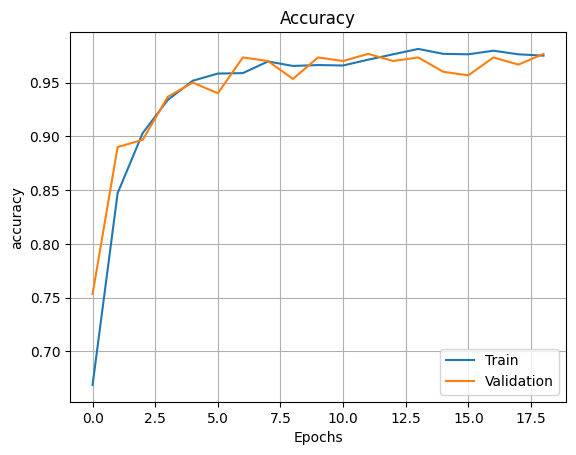

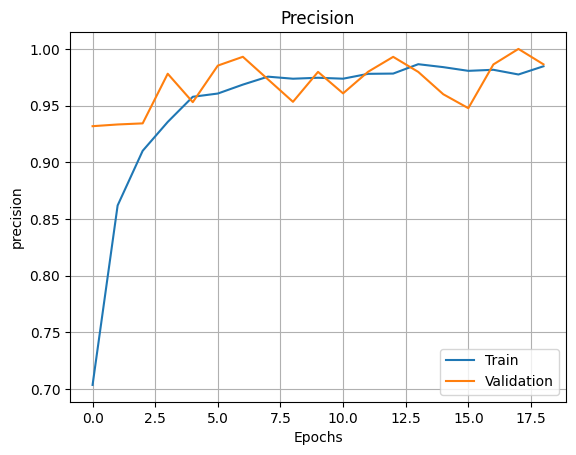

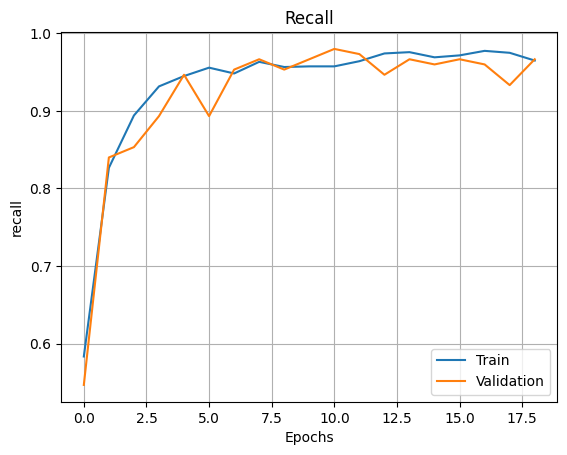

In [ ]:
# Eğitim metriklerini görselleştir
def plot_training(history):
    metrics = ['accuracy', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Validation')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history_1)

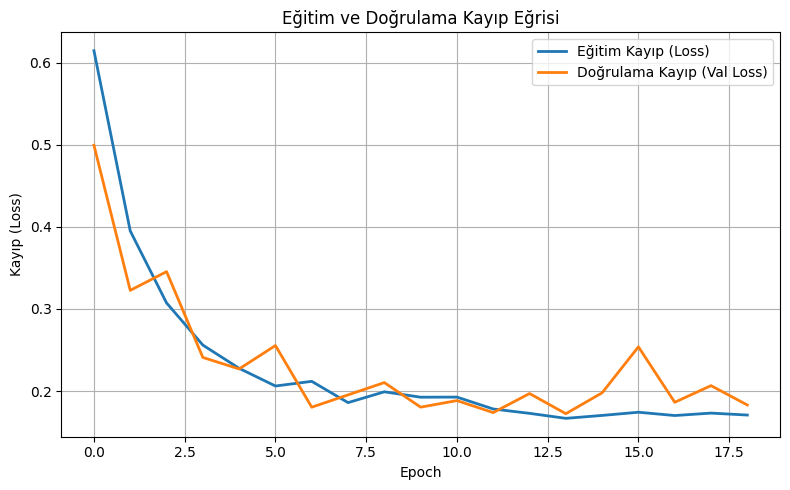

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)', linewidth=2)
    plt.title('Eğitim ve Doğrulama Kayıp Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(history_1)

#### Modelin Test Edilmesi

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 209s 23s/step
Optimal threshold: 0.582084


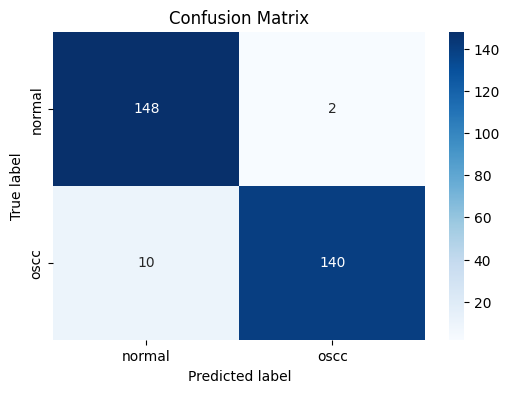

=== Classification Report ===
              precision    recall  f1-score   support

      normal       0.94      0.99      0.96       150
        oscc       0.99      0.93      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

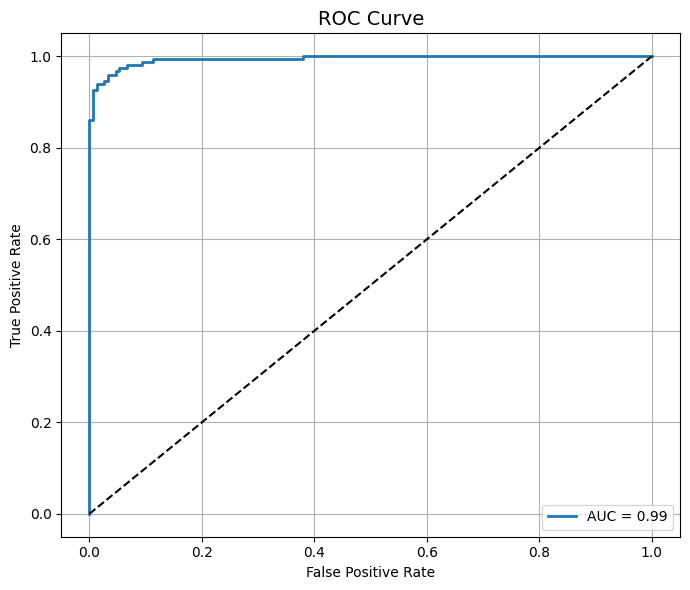

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa Skoru:", kappa)

Cohen's Kappa Skoru: 0.92


**Modelin Kaydedilmesi**

In [ ]:
model.save('/content/drive/MyDrive/agiz_kanseri_resnet_cbam_yeni.keras')

##### Grad CAM

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="post_relu", pred_index=None):
    """
    img_array: (1,H,W,3), [0,1] normalize
    last_conv_layer_name: ResNet50V2 için 'post_relu' veya 'conv5_block3_out'
    """
    # 1) Hedef katmanı al
    last_conv_layer = model.get_layer(last_conv_layer_name)

    # 2) Grad model (tekil tensörler kullan)
    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array, training=False)

        # Liste gelirse ilkini al
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        preds = tf.convert_to_tensor(preds)

        # Binary (sigmoid, 1 nöron) -> tek nöronu hedefle
        if pred_index is None:
            if preds.shape[-1] == 1:
                class_channel = preds[:, 0]
            else:
                pred_index = tf.argmax(preds[0])
                class_channel = preds[:, pred_index]
        else:
            class_channel = preds[:, pred_index]

        grads = tape.gradient(class_channel, conv_outputs)

    # 3) Kanal başına global ortalama (ağırlıklar)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (C,)

    # 4) Ağırlıkları uygula ve ReLU + normalize
    conv_outputs = conv_outputs[0]  # (H,W,C)
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)  # (H,W)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-12)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name="post_relu", alpha=0.5, target_size=(224,224)):
    # 1) Görseli yükle ve normalize et
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 2) Heatmap üret
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name=last_conv_layer_name)

    # 3) Orijinal üzerine bindir
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (target_size[1], target_size[0]))
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 1 - alpha, heatmap_colored, alpha, 0)

    # 4) Göster
    plt.figure(figsize=(11, 4))
    plt.suptitle(f"Grad-CAM (layer: {last_conv_layer_name})", y=1.02)
    plt.subplot(1, 3, 1); plt.title("Original");     plt.imshow(img_cv[..., ::-1]); plt.axis("off")
    plt.subplot(1, 3, 2); plt.title("Grad-CAM");     plt.imshow(heatmap, cmap='jet'); plt.axis("off")
    plt.subplot(1, 3, 3); plt.title("Superimposed"); plt.imshow(superimposed[..., ::-1]); plt.axis("off")
    plt.tight_layout(); plt.show()

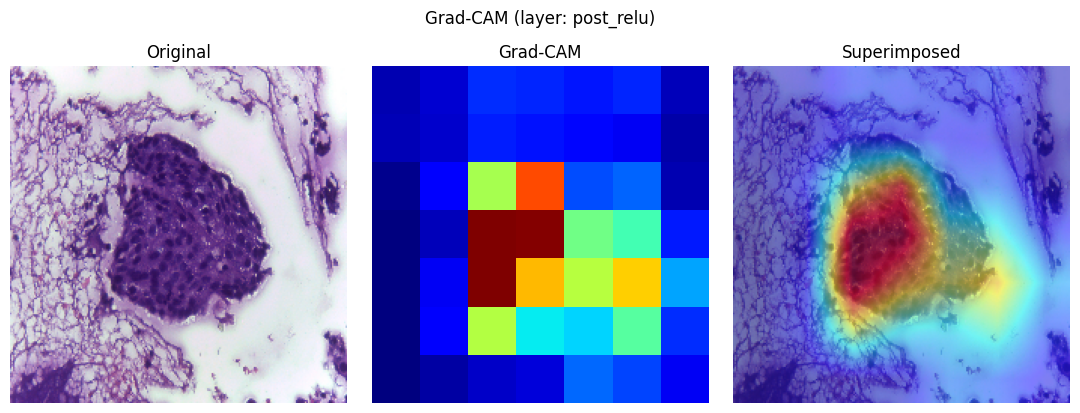

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
display_gradcam(img_path, model, last_conv_layer_name="post_relu")

# display_gradcam(img_path, model, last_conv_layer_name="conv5_block3_out")

#### Integrated Gradients

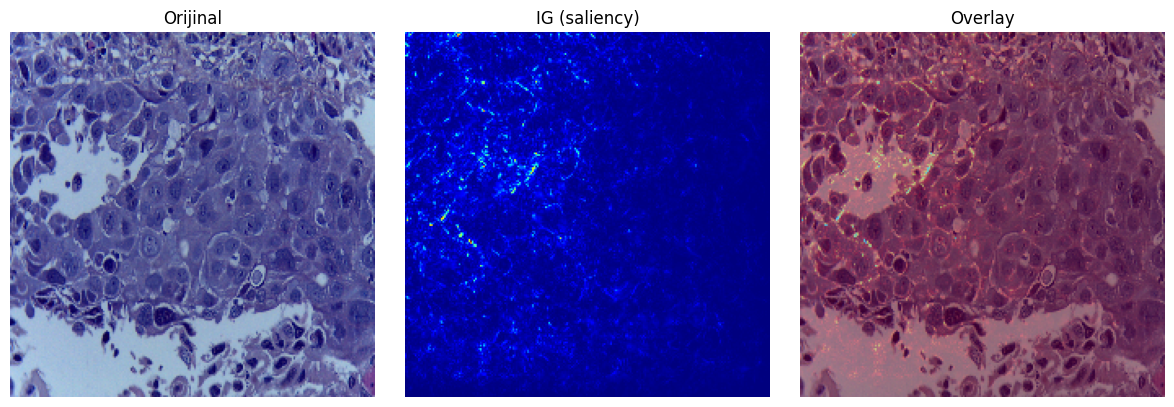

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image

# --- Yardımcılar ---
@tf.function
def compute_gradients(images):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images, training=False)  # önemli: training=False
        if isinstance(preds, (list, tuple)):
            preds = preds[0]
        output = preds[:, 0]  # binary: tek nöron
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, img_batch, m_steps=50, method="trapezoid"):
    # baseline ve img_batch şekilleri: (1, H, W, 3)
    alphas = tf.linspace(0.0, 1.0, m_steps)
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = img_batch - baseline
    interpolated = baseline + alphas_x * delta   # (m, H, W, 3)

    grads = compute_gradients(interpolated)      # (m, H, W, 3)

    if method == "trapezoid" and m_steps > 1:
        grads = (grads[1:] + grads[:-1]) / 2.0   # trapez yaklaşımı

    avg_grads = tf.reduce_mean(grads, axis=0).numpy()      # (H, W, 3)
    integrated = (img_batch.numpy()[0] - baseline.numpy()[0]) * avg_grads  # (H,W,3)
    return integrated

def visualize_ig(img_path, target_size=(224,224), m_steps=50, baseline_type="black", save_path=None):
    # 1) görseli yükle
    img = image.load_img(img_path, target_size=target_size)
    img_arr = image.img_to_array(img)
    img_batch = np.expand_dims(img_arr, axis=0) / 255.0

    # 2) baseline seç
    if baseline_type == "black":
        baseline = tf.zeros_like(img_batch)
    elif baseline_type == "white":
        baseline = tf.ones_like(img_batch)
    elif baseline_type == "blur":
        # basit blur baseline
        blurred = cv2.GaussianBlur(img_arr, (51,51), 0) / 255.0
        baseline = tf.convert_to_tensor(np.expand_dims(blurred, 0), dtype=tf.float32)
    else:
        raise ValueError("baseline_type 'black' | 'white' | 'blur' olmalı.")

    # 3) IG hesapla
    ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch, dtype=tf.float32),
                              m_steps=m_steps, method="trapezoid")

    # 4) tek kanal önem haritası (abs ve normalize)
    attr = np.mean(np.abs(ig), axis=-1)
    attr -= attr.min()
    attr /= (attr.max() + 1e-12)

    # 5) görselleştir
    heatmap = cv2.applyColorMap(np.uint8(255 * attr), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_arr.astype(np.uint8), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title("Orijinal");     plt.imshow(img_arr.astype(np.uint8)); plt.axis("off")
    plt.subplot(1,3,2); plt.title("IG (saliency)"); plt.imshow(attr, cmap="jet");         plt.axis("off")
    plt.subplot(1,3,3); plt.title("Overlay");       plt.imshow(overlay);                  plt.axis("off")
    plt.tight_layout(); plt.show()

    if save_path is not None:
        cv2.imwrite(save_path, overlay[..., ::-1])  # BGR yazdığı için ters çeviriyoruz
        print("Kaydedildi ->", save_path)

# --- KULLANIM ---
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)  # ör: save_path="/content/ig_overlay.png"


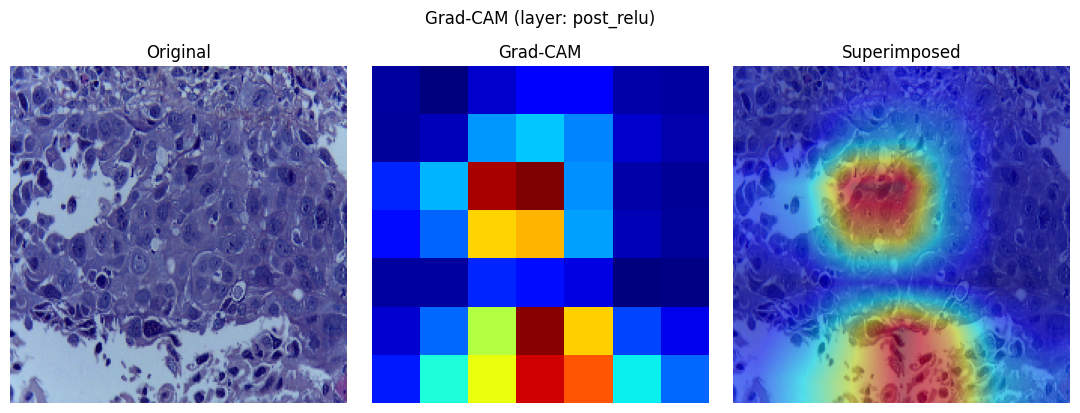

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"
display_gradcam(img_path, model, last_conv_layer_name='post_relu')

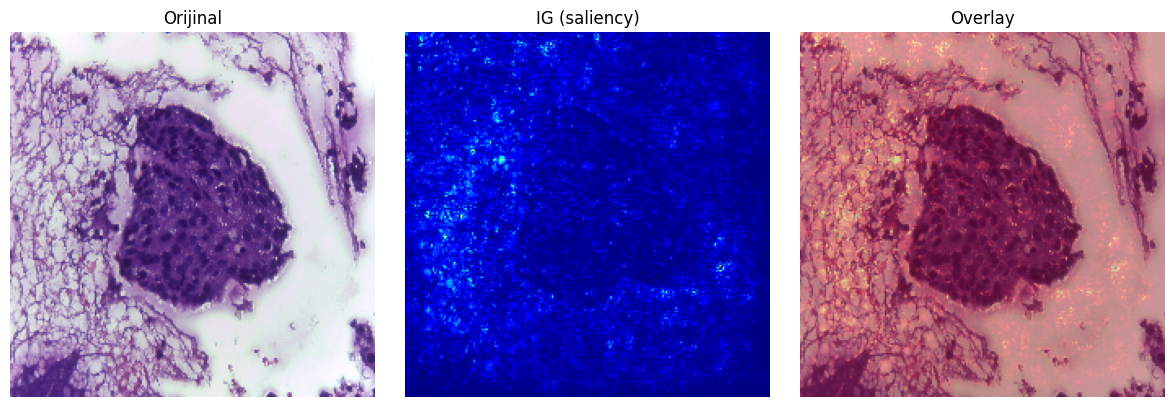

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)

**Modelin Yüklenmesi**

In [ ]:
from tensorflow.keras.models import load_model
# Import the custom objects
# from Rv1_ps_Fd8Dl import ChannelMean, ChannelMax # Remove this line

custom_objects = {
    'ChannelMean': ChannelMean,
    'ChannelMax': ChannelMax,
    # Add other custom objects if any
}

model = load_model(
    '/content/drive/MyDrive/agiz_kanseri_resnet_cbam_yeni.keras',
    custom_objects=custom_objects
)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

#img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"  # örnek yol
#img_path="/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_468.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # (1, 224, 224, 3)
img_array = img_array / 255.0  # Normalize

In [ ]:
pred_prob = model.predict(img_array)[0][0]

threshold = optimal_threshold  # veya ROC ile optimize ettiğin değer
pred_label = "OSCC" if pred_prob > threshold else "Normal"

print(f"Model çıktısı (olasılık): {pred_prob:.4f}")
print(f"Tahmin edilen sınıf: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Model çıktısı (olasılık): 0.9897
Tahmin edilen sınıf: OSCC


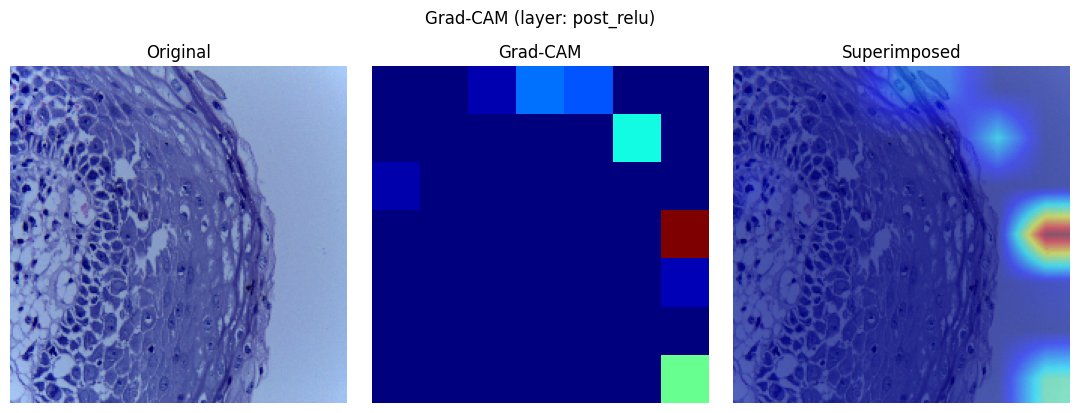

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
display_gradcam(img_path, model, last_conv_layer_name='post_relu')

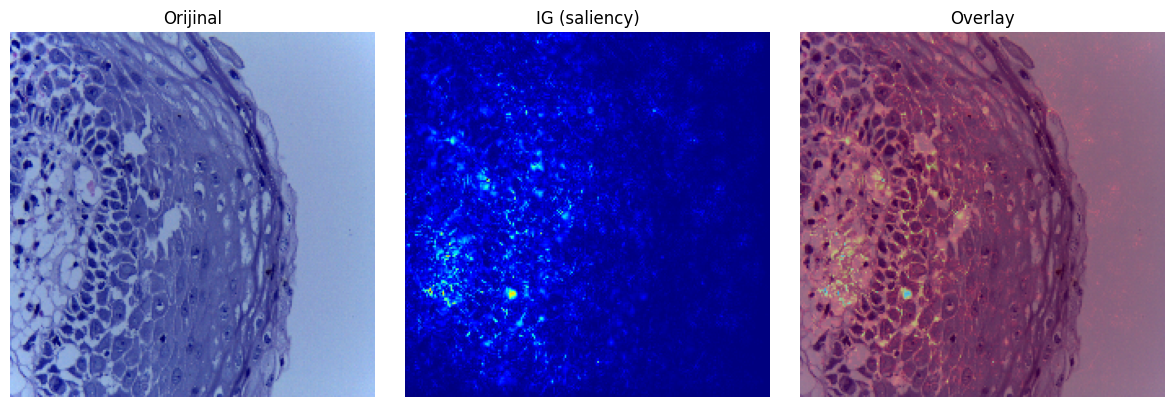

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
visualize_ig(img_path, target_size=(224,224), m_steps=64, baseline_type="black",
             save_path=None)

In [ ]:
test_dir = "/content/drive/MyDrive/Dataset/test"
val_test_datagen = ImageDataGenerator(rescale=1./255)
image_size = (224, 224)
test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Test için önemli
)

Found 126 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 43s 10s/step
Optimal threshold: 0.2232567


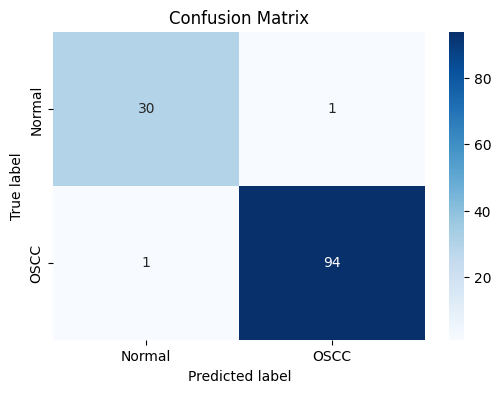

=== Classification Report ===
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97        31
        OSCC       0.99      0.99      0.99        95

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix hesapla
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimlerini test_data’dan al (0: Normal, 1: OSCC gibi)
class_names = list(test_data.class_indices.keys())

# Görselleştir
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification raporu
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))